In [1]:
import pandas as pd
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

# Constructing Synthetic Basket

1. Calculates the cointegration score of each NASDAQ100 component present in 2018 and 2019 against the QQQ ETF for the year 2018
2. Selects subset of NASDAQ100 components that have a cointegration p-value below 0.2
3. Create a powerset of the cointegrated subset and calculate the cointegration score of the subset against the QQQ ETF
4. Select most cointegrated subset as our synthetic basket which is, by design, cointegrated with QQQ in 2018

In [2]:
tickers = pd.read_csv("../data/nasdaq_comps_2016-2020.csv")

### Cointegration of Individual ETF Components
We use the Engle-Granger Two-Step method in our initial step to calculate the cointegration between each NASDAQ100 component and the QQQ ETF.  NASDAQ100 components are chosen if they are a component during both our basket formation period (2018) and our trading period (2019).

In [3]:
tickers = list(set(tickers['2019']).intersection(set(tickers['2018'])))
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
cointegrationResultsIndividual = fn.runCointTestIndividual(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
FISV
[*********************100%***********************]  1 of 1 completed
GOOG
[*********************100%***********************]  1 of 1 completed
SNPS
[*********************100%***********************]  1 of 1 completed
JBHT
[*********************100%***********************]  1 of 1 completed
MAR
[*********************100%***********************]  1 of 1 completed
ILMN
[*********************100%***********************]  1 of 1 completed
ALGN
[*********************100%***********************]  1 of 1 completed
MYL
[*********************100%***********************]  1 of 1 completed
EBAY
[*********************100%***********************]  1 of 1 completed
WDC
[*********************100%***********************]  1 of 1 completed
ULTA
[*********************100%***********************]  1 of 1 completed
TSLA
[*********************100%********************

In [4]:
cointegrationResultsIndividual.head(10)

,ticker,t-stat,pval
24,HAS,-3.476138,0.034570
42,AAPL,-3.268703,0.059170
31,TTWO,-3.186715,0.072178
67,IDXX,-3.156778,0.077458
13,SBUX,-3.125705,0.083256
22,CTAS,-3.089389,0.090454
50,ALXN,-2.892722,0.137956
6,ALGN,-2.865327,0.145781
72,BMRN,-2.797488,0.166485
46,PAYX,-2.703154,0.198446


### Synthetic Basket
Based on the cointegration test performed, we select the subset of the NASDAQ100 components that have a cointegration test p-value of less than 0.2 to be candidates for our synthetic basket.  We create every possible basket that can be constructed by any combination of the components in our subset and run another cointegration test.  The most cointegrated synthetic basket is selected to be traded in the trading period (2019).

In [5]:
subset = cointegrationResultsIndividual.loc[cointegrationResultsIndividual['pval'] <= 0.2]
tickers = subset['ticker'].tolist()
etf = 'QQQ'
start = '2018-01-01'
end = '2018-12-31'
synthetic_asset_rankEG = fn.runCointTestBasketsEG(etf, tickers, start, end)
synthetic_asset_rankJoh = fn.runCointTestBasketsJoh(etf, tickers, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed
0 done, out of a total of  1013
500 done, out of a total of  1013
1000 done, out of a total of  1013
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed
0 done, out of a total of  1013
500 done, out of a total of  1013
1000 done, out of a total of  1013


### Engle-Granger Two-Step Method
The first cointegration test we use is the Engle-Granger Two-Step Method to evaluate the cointegration of each of our baskets with QQQ.  This method only compares one variable against another so in order to aggregate the basket, we sum the prices of each component of the basket.  The cointegration of QQQ with this sum is then evaluated and ranked to determine which basket is the most highly cointegrated with QQQ.

In [6]:
synthetic_asset_rankEG.head()

,ticker,t-stat,pval
973,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, PAYX)",-5.112294,0.000102
857,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN)",-5.082241,0.000116
972,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, BMRN)",-5.054691,0.000130
984,"(HAS, AAPL, SBUX, CTAS, ALXN, ALGN, BMRN, PAYX)",-5.047519,0.000135
1008,"(HAS, AAPL, TTWO, SBUX, CTAS, ALXN, ALGN, BMRN...",-5.047064,0.000135


### Johansen Test
The second cointegration test we use is the Johansen Test.  This test calculates the cointegrated relationships between multiple variables and can account for multiple cointegrating vectors.  The input is all the price data for each individual stock in our basket as well as QQQ.  The most cointegrated basket is then chosen to be traded.

In [7]:
synthetic_asset_rankJoh.head()

,ticker,critical-values,trace-stat
697,"[HAS, TTWO, IDXX, SBUX, CTAS, ALXN]","[2.7055, 3.8415, 6.6349]",0.045069
446,"[HAS, TTWO, SBUX, CTAS, ALXN]","[2.7055, 3.8415, 6.6349]",0.049130
895,"[HAS, TTWO, IDXX, SBUX, CTAS, ALXN, PAYX]","[2.7055, 3.8415, 6.6349]",0.072650
719,"[HAS, TTWO, SBUX, CTAS, ALXN, PAYX]","[2.7055, 3.8415, 6.6349]",0.078982
432,"[HAS, TTWO, IDXX, SBUX, ALXN]","[2.7055, 3.8415, 6.6349]",0.087837


# Constructing Multivariate Kalman Filter
1. Construct a multivariate Kalman Filter with each stock in our synthetic basket collectively filtered against QQQ for the year 2019
2. Using the outputted state means, calculate the value of our synthetic basket
3. Generate the spread between our synthetic basket and the QQQ ETF.  We expect this spread to be mean-reverting

In [8]:
# Start from 01-01-2019 and end at 12-31-2019
qqq = pd.read_csv("../data/qqqMinute2019.csv")
has = pd.read_csv("../data/hasMinute2019.csv")
aapl = pd.read_csv("../data/aaplMinute2019.csv")
ttwo = pd.read_csv("../data/ttwoMinute2019.csv")
idxx = pd.read_csv("../data/idxxMinute2019.csv")
sbux = pd.read_csv("../data/sbuxMinute2019.csv")
ctas = pd.read_csv("../data/ctasMinute2019.csv")
alxn = pd.read_csv("../data/alxnMinute2019.csv")
algn = pd.read_csv("../data/algnMinute2019.csv")
payx = pd.read_csv("../data/payxMinute2019.csv")

In [9]:
qqq = qqq.set_index('date_time')
qqq = qqq.rename(columns={'close': 'qqqclose'})

has = has.set_index('date_time')
has = has.rename(columns={'close': 'hasclose'})

aapl = aapl.set_index('date_time')
aapl = aapl.rename(columns={'close': 'aaplclose'})

ttwo = ttwo.set_index('date_time')
ttwo = ttwo.rename(columns={'close': 'ttwoclose'})

idxx = idxx.set_index('date_time')
idxx = idxx.rename(columns={'close': 'idxxclose'})

sbux = sbux.set_index('date_time')
sbux = sbux.rename(columns={'close': 'sbuxclose'})

ctas = ctas.set_index('date_time')
ctas = ctas.rename(columns={'close': 'ctasclose'})

alxn = alxn.set_index('date_time')
alxn = alxn.rename(columns={'close': 'alxnclose'})

algn = algn.set_index('date_time')
algn = algn.rename(columns={'close': 'algnclose'})

payx = payx.set_index('date_time')
payx = payx.rename(columns={'close': 'payxclose'})

### Dataset for Engle-Granger Basket

In [10]:
eg_basket_data = qqq[['qqqclose']].join([has[['hasclose']], aapl[['aaplclose']], ttwo[['ttwoclose']], sbux[['sbuxclose']], 
                               ctas[['ctasclose']], alxn[['alxnclose']], algn[['algnclose']], payx[['payxclose']]], 
                              how='outer')
eg_basket_data = eg_basket_data.dropna()
eg_basket_data.tail(10)

,qqqclose,hasclose,aaplclose,ttwoclose,sbuxclose,ctasclose,alxnclose,algnclose,payxclose
2019-12-31 15:40:00,212.365,105.6000,293.0850,122.1000,87.7800,268.5400,108.0700,278.0500,84.9600
2019-12-31 15:41:00,212.400,105.5905,293.1800,122.1000,87.7700,268.8500,108.1340,278.2650,84.9300
2019-12-31 15:42:00,212.410,105.5800,293.2000,122.1067,87.7800,268.7100,108.0639,278.2900,84.9900
2019-12-31 15:43:00,212.415,105.5800,293.2600,122.1300,87.8200,268.7476,108.1101,278.2900,85.0000
2019-12-31 15:44:00,212.450,105.6100,293.3600,122.1300,87.8550,268.7650,108.1300,278.3600,84.9833
2019-12-31 15:45:00,212.450,105.5900,293.5099,122.1200,87.8600,268.7300,108.1300,278.5800,84.9900
2019-12-31 15:46:00,212.490,105.6300,293.4300,122.1500,87.8547,268.8400,108.1300,278.3543,84.9500
2019-12-31 15:47:00,212.495,105.5500,293.4270,122.1584,87.8550,268.7700,108.1176,278.2500,84.9450
2019-12-31 15:48:00,212.460,105.5400,293.3350,122.2000,87.8450,268.8000,108.1645,278.4100,84.9600
2019-12-31 15:49:00,212.430,105.5100,293.2700,122.2100,87.8150,268.7950,108.1300,278.4700,84.9300


### Dataset for Johansen Basket

In [11]:
joh_basket_data = qqq[['qqqclose']].join([has[['hasclose']], ttwo[['ttwoclose']], idxx[['idxxclose']], 
                               sbux[['sbuxclose']], ctas[['ctasclose']], alxn[['alxnclose']]], how='outer')
joh_basket_data = joh_basket_data.dropna()
joh_basket_data.tail(20)

,qqqclose,hasclose,ttwoclose,idxxclose,sbuxclose,ctasclose,alxnclose
2019-12-31 15:30:00,212.345,105.7300,122.2000,260.78,87.6850,268.2800,108.0100
2019-12-31 15:31:00,212.330,105.7100,122.1600,260.86,87.7050,268.3100,107.9500
2019-12-31 15:32:00,212.355,105.6972,122.1200,260.94,87.7130,268.3200,107.9500
2019-12-31 15:33:00,212.360,105.6900,122.1800,260.85,87.7250,268.4400,107.9550
2019-12-31 15:34:00,212.365,105.6900,122.2200,260.91,87.7700,268.4900,107.9700
2019-12-31 15:35:00,212.385,105.6800,122.1800,260.89,87.7650,268.4800,107.9850
2019-12-31 15:36:00,212.370,105.6500,122.2000,260.92,87.7600,268.4793,108.0387
2019-12-31 15:37:00,212.350,105.6200,122.1700,260.73,87.7600,268.4900,107.9800
2019-12-31 15:38:00,212.385,105.6200,122.1298,260.51,87.7600,268.5600,108.0000
2019-12-31 15:39:00,212.355,105.6044,122.1050,260.52,87.7500,268.5800,108.0300


In [12]:
syntheticAssetLogPriceEG = eg_basket_data[['hasclose', 'aaplclose', 'ttwoclose', 'sbuxclose', 
                               'ctasclose', 'alxnclose', 'algnclose', 'payxclose']].apply(np.log)
qqqLogPriceEG = np.log(eg_basket_data['qqqclose'].values)

syntheticAssetLogPriceJoh = joh_basket_data[['hasclose', 'ttwoclose', 'sbuxclose', 
                               'idxxclose', 'ctasclose', 'alxnclose']].apply(np.log)
qqqLogPriceJoh = np.log(joh_basket_data['qqqclose'].values)

### Multivariate Kalman Filter
At every timestep, the Kalman Filter outputs estimates for the hedge ratios of each component in our synthetic basket as well as an intercept term.  In other words, it gave us all the tools to calculate an estimate for the price of QQQ based on the price of each component in our basket.  The residuals of this estimate form a mean-reverting and stationary process that we can take advantage of.  

We model QQQ price with the following formula:
$$ \widehat{log(price_{QQQ})} = \sum_{n=1}^{N} \beta_{n} * log(price_{n}) $$

Using the Kalman Filter, we are able to calculate what the values for $ \beta_{n} $ are for each time-period.

We expect the residuals of this model to be mean-reverting and stationary.

$$ residuals = log(price_{QQQ}) - \widehat{log(price_{QQQ})} $$

In [13]:
kf_EG = fn.multivariateKalmanFilter(syntheticAssetLogPriceEG, qqqLogPriceEG)
state_means_eg, state_covs_eg = kf_EG.filter(qqqLogPriceEG)
basket_size_eg = len(syntheticAssetLogPriceEG.columns)
slopes_eg = state_means_eg[:, np.arange(0, basket_size_eg, 1)]
#intercept = state_means[:, basket_size]

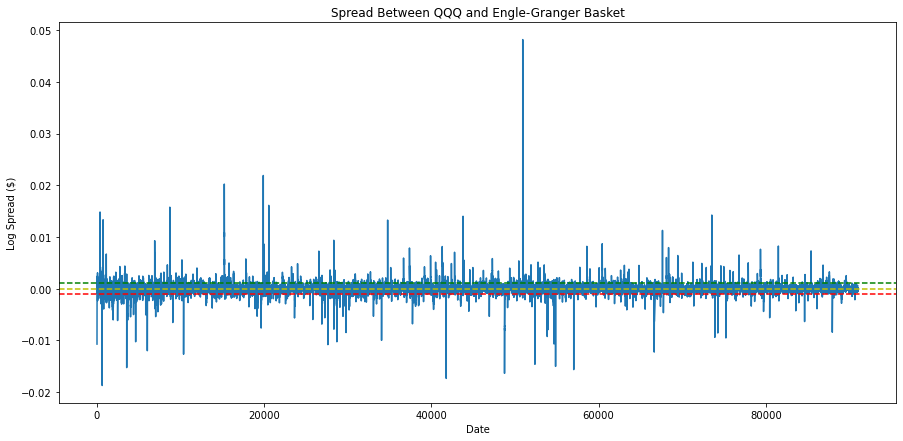

In [14]:
syntheticAssetEstimateEG = [np.dot(slopes_eg[i], syntheticAssetLogPriceEG.values[i].T) for i in range(len(slopes_eg))]
spread_ts_eg = qqqLogPriceEG - syntheticAssetEstimateEG
plt.figure(figsize = (15,7))
plt.plot(spread_ts_eg)
plt.title("Spread Between QQQ and Engle-Granger Basket")
plt.ylabel("Log Spread ($)")
plt.xlabel("Date")

In [15]:
kf_Joh = fn.multivariateKalmanFilter(syntheticAssetLogPriceJoh, qqqLogPriceJoh)
state_means_joh, state_covs_joh = kf_Joh.filter(qqqLogPriceJoh)
basket_size_joh = len(syntheticAssetLogPriceJoh.columns)
slopes_joh = state_means_joh[:, np.arange(0, basket_size_joh, 1)]
#intercept = state_means[:, basket_size]

Text(0.5, 0, 'Date')

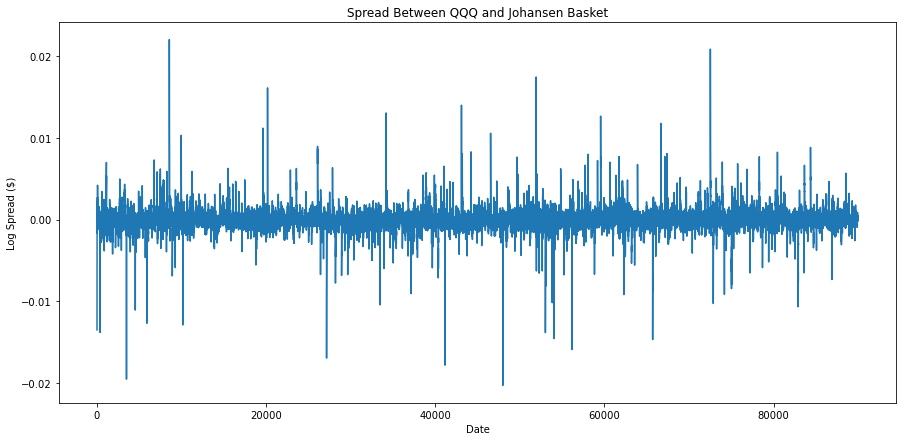

In [16]:
syntheticAssetEstimateJoh = [np.dot(slopes_joh[i], syntheticAssetLogPriceJoh.values[i].T) for i in range(len(slopes_joh))]
spread_ts_joh = qqqLogPriceJoh - syntheticAssetEstimateJoh
plt.figure(figsize = (15,7))
plt.plot(spread_ts_joh)
plt.title("Spread Between QQQ and Johansen Basket")
plt.ylabel("Log Spread ($)")
plt.xlabel("Date")

In [17]:
c_list_eg = ['hasSlope', 'aaplSlope', 'ttwoSlope', 'sbuxSlope', 
                               'ctasSlope', 'alxnSlope', 'algnSlope', 'payxSlopes']
c_list_joh = ['hasSlope', 'ttwoSlope', 'sbuxSlope', 
                               'idxxSlope', 'ctasSlope', 'alxnSlope']

eg_basket_data[c_list_eg] = pd.DataFrame(slopes_eg, columns=c_list_eg, index=eg_basket_data.index)
joh_basket_data[c_list_joh] = pd.DataFrame(slopes_joh, columns=c_list_joh, index=joh_basket_data.index)

eg_basket_data['logspread'] = spread_ts_eg
eg_basket_data['spread'] = np.exp(spread_ts_eg)

joh_basket_data['logspread'] = spread_ts_joh
joh_basket_data['spread'] = np.exp(spread_ts_joh)

eg_basket_data = eg_basket_data.reset_index()
eg_basket_data = eg_basket_data.rename(columns={'index': 'datetime'})
joh_basket_data = joh_basket_data.reset_index()
joh_basket_data = joh_basket_data.rename(columns={'index': 'datetime'})

In [18]:
#eg_basket_data.to_csv("../data/eg_basket_data.csv", index=False)
#joh_basket_data.to_csv("../data/joh_basket_data.csv", index=False)